# Structural and Graph-Theoretic Signals for Human vs. AI Text Detection: A Statistical and Linear Modeling Study on HC3 dataset

### 1. Dataset Loading & Sampling
   Loads the HC3 parquet dataset, converts to pandas, and selects a 500-pair sample for statistical analysis 

In [1]:
import os
import re
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from datasets import load_dataset
from tqdm import tqdm
from scipy import stats
import networkx as nx
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
sns.set_theme(style="whitegrid")

# 1. Load the local Parquet file
file_path = "hc3_local/hc3_train.parquet"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: {file_path} not found. Please run the download script first.")

print("Loading dataset...")
dataset = load_dataset("parquet", data_files=file_path, split="train")
raw_df = dataset.to_pandas()
print("Dataset loaded.")

# We'll analyze 500 samples for a statistically significant result
SAMPLE_SIZE = 500

sample_raw_df = raw_df.sample(
    n=SAMPLE_SIZE,
    random_state=42
)

nlp = spacy.load("en_core_web_sm")

Loading dataset...
Dataset loaded.


### 2. Preprocessing & Basic Length Features
   Extracts per-answer features: character length, word count, unique word count, and builds a human/AI labeled dataframe 

In [10]:
def _ensure_list(val):
    if isinstance(val, np.ndarray):
        val = val.tolist()
    if isinstance(val, (list, tuple)):
        return list(val)
    try:
        if pd.isna(val):
            return []
    except Exception:
        pass
    return [val]

def build_records(source_df):
    records = []
    for idx, row in source_df.iterrows():
        qid = idx
        source = row.get("source", "unknown")
        question = row.get("question", "")
        humans = _ensure_list(row.get("human_answers", []))
        bots = _ensure_list(row.get("chatgpt_answers", []))
        pair = []
        if len(humans) > 0:
            pair.append((humans[0], "human"))
        if len(bots) > 0:
            pair.append((bots[0], "ai"))
        for text, label in pair:
            if not isinstance(text, str):
                continue
            tokens = re.findall(r"[A-Za-z']+", text.lower())
            records.append({
                "qid": qid,
                "label": label,
                "source": source,
                "question": question,
                "text": text,
                "char_len": len(text),
                "word_len": len(tokens),
                "uniq_words": len(set(tokens)),
            })
    return pd.DataFrame(records)

# ── SAMPLE (500 pairs) ── used for EDA, t-tests, graphs, visualisations
sample_raw_df = raw_df.head(SAMPLE_SIZE)
dist_sample = build_records(sample_raw_df)

# ── FULL dataset ── used for all model training / evaluation
dist_df = build_records(raw_df)

print(f"Sample rows : {len(dist_sample)}  (EDA / graphs)")
print(f"Full rows   : {len(dist_df)}  (model training)")
dist_sample.head()


Sample rows : 1000  (EDA / graphs)
Full rows   : 48189  (model training)


,qid,label,source,question,text,char_len,word_len,uniq_words
0,0,human,reddit_eli5,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",600,102,59
1,0,ai,reddit_eli5,"Why is every book I hear about a "" NY Times # ...",There are many different best seller lists tha...,1114,209,87
2,1,human,reddit_eli5,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,207,37,29
3,1,ai,reddit_eli5,"If salt is so bad for cars , why do we use it ...",Salt is used on roads to help melt ice and sno...,1148,199,110
4,2,human,reddit_eli5,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,784,145,89


### 3. Linguistic Feature Extraction (spaCy)
   Computes syntactic tree depth, pronoun density, lexical diversity (TTR), and subordination complexity markers 

In [11]:
def extract_features(text):
    doc = nlp(text[:12000])
    tokens = [t for t in doc if not t.is_punct]
    if not tokens: return None

    # 1. Syntactic Depth
    depths = []
    for sent in doc.sents:
        try:
            d = max([len(list(t.ancestors)) for t in sent])
            depths.append(d)
        except: continue
    avg_depth = np.mean(depths) if depths else 0

    # 2. Pronoun Density
    pronoun_count = sum(1 for t in doc if t.pos_ == "PRON")

    # 3. Lexical Diversity (TTR)
    ttr = len(set(t.lower_ for t in tokens)) / len(tokens)

    # 4. Sentence Complexity
    sconj_count = sum(1 for t in doc if t.pos_ == "SCONJ")

    return {
        "tree_depth": avg_depth,
        "pronoun_density": pronoun_count / len(tokens),
        "lexical_diversity": ttr,
        "complexity_markers": sconj_count / len(tokens)
    }

# ── Run on the 500-pair SAMPLE only ──
print(f"Analyzing {SAMPLE_SIZE} pairs (sample)...")

human_data = []
ai_data = []

for qid, group in dist_sample.groupby("qid"):
    h_text = group[group["label"] == "human"]["text"].values
    a_text = group[group["label"] == "ai"]["text"].values

    if len(h_text) == 0 or len(a_text) == 0:
        continue

    h = extract_features(h_text[0])
    a = extract_features(a_text[0])

    if h and a:
        human_data.append(h)
        ai_data.append(a)

df_h = pd.DataFrame(human_data)
df_a = pd.DataFrame(ai_data)

df_h = pd.DataFrame(human_data)
df_a = pd.DataFrame(ai_data)

# Summary
print("\n" + "="*45)
print(f"{'Feature':<20} | {'Human Mean':<10} | {'AI Mean':<10}")
print("-" * 45)
for feat in df_h.columns:
    print(f"{feat:<20} | {df_h[feat].mean():10.4f} | {df_a[feat].mean():10.4f}")
print("="*45)


Analyzing 500 pairs (sample)...

Feature              | Human Mean | AI Mean   
---------------------------------------------
tree_depth           |     4.7654 |     6.3414
pronoun_density      |     0.1040 |     0.0802
lexical_diversity    |     0.7369 |     0.5085
complexity_markers   |     0.0287 |     0.0314


### 4. Statistical Testing (T-tests)
Performs paired t-tests comparing human vs AI means; all core linguistic features show strong statistical significance 

In [12]:
def cohens_d_paired(x, y):
   diffs = x - y
   return diffs.mean() / diffs.std(ddof=1)

print("="*95)
print(f"{'Feature':<20} | {'Mean Δ (AI-H)':<15} | {'t-stat':<10} | {'P-Value':<12} | {'Cohen d':<10} | {'Magnitude'}")
print("-"*95)

for feat in df_h.columns:
    ai_vals = df_a[feat]
    h_vals  = df_h[feat]

    # paired test
    t_stat, p_val = stats.ttest_rel(ai_vals, h_vals)

    # effect size
    d = cohens_d_paired(ai_vals, h_vals)

    # interpret magnitude
    if abs(d) < 0.2:
        mag = "negligible"
    elif abs(d) < 0.5:
        mag = "small"
    elif abs(d) < 0.8:
        mag = "medium"
    else:
        mag = "large"

    mean_diff = (ai_vals - h_vals).mean()

    print(f"{feat:<20} | {mean_diff:15.4f} | {t_stat:10.4f} | {p_val:12.4e} | {d:10.4f} | {mag}")

print("="*95)
print("Paired t-test (AI vs Human per question)")

Feature              | Mean Δ (AI-H)   | t-stat     | P-Value      | Cohen d    | Magnitude
-----------------------------------------------------------------------------------------------
tree_depth           |          1.5760 |    20.3989 |   1.0248e-67 |     0.9123 | large
pronoun_density      |         -0.0238 |   -10.0743 |   7.4695e-22 |    -0.4505 | small
lexical_diversity    |         -0.2285 |   -34.9395 |  3.5721e-136 |    -1.5625 | large
complexity_markers   |          0.0027 |     2.3260 |   2.0419e-02 |     0.1040 | negligible
Paired t-test (AI vs Human per question)


### 5. Distribution & Permutation Testing
Visualizes word/character length distributions and runs a permutation test confirming significant mean length differences 


Rows per class (sample):
 label
human    500
ai       500
Name: count, dtype: int64

Sources (top 5, sample):
 source
reddit_eli5    1000
Name: count, dtype: int64


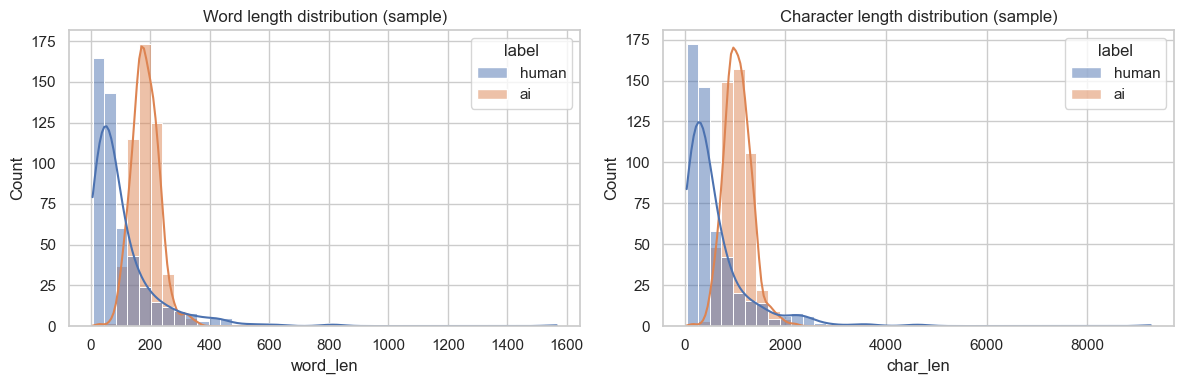

Observed mean word length diff (AI - Human): 78.92
Permutation p-value (n=300): 0.000


In [13]:
# ── Distribution checks on SAMPLE ──
print("Rows per class (sample):\n", dist_sample['label'].value_counts())
print("\nSources (top 5, sample):\n", dist_sample['source'].value_counts().head())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(dist_sample, x="word_len", hue="label", kde=True, bins=40, ax=axes[0])
axes[0].set_title("Word length distribution (sample)")

sns.histplot(dist_sample, x="char_len", hue="label", kde=True, bins=40, ax=axes[1])
axes[1].set_title("Character length distribution (sample)")
plt.tight_layout()
plt.show()

# Permutation test on the sample
rng = np.random.default_rng(0)
obs_diff = (dist_sample.groupby("label")["word_len"].mean().loc["ai"]
            - dist_sample.groupby("label")["word_len"].mean().loc["human"])
perm_diffs = []
for _ in range(300):
    shuffled = dist_sample["label"].sample(frac=1, replace=False,
                                           random_state=rng.integers(0, int(1e9))).values
    perm_df = dist_sample.assign(shuffled_label=shuffled)
    diff = perm_df.groupby("shuffled_label")["word_len"].mean().diff().iloc[-1]
    perm_diffs.append(diff)
p_value = (np.abs(perm_diffs) >= abs(obs_diff)).mean()

print(f"Observed mean word length diff (AI - Human): {obs_diff:.2f}")
print(f"Permutation p-value (n=300): {p_value:.3f}")


### 6. Token Co-occurrence Graph Construction
Defines two graph builders — one over **all tokens** (raw) and one over **content words only** (stopwords removed) — then builds all four sample graphs used for metrics and visualisation in §7–§8.

In [14]:
TOP_K = 100          # Fixed globally — never change mid-analysis
MIN_NODES = 10       # Skip unstable tiny graphs

In [15]:
def build_cooccurrence_graph(text, top_k=TOP_K):
    tokens = re.findall(r"[A-Za-z']+", text.lower())
    if len(tokens) < 5:
        return None

    token_freq = {}
    edges = {}

    for tok in tokens:
        token_freq[tok] = token_freq.get(tok, 0) + 1

    for a, b in zip(tokens, tokens[1:]):
        if a == b:
            continue
        edges[(a, b)] = edges.get((a, b), 0) + 1

    if not token_freq:
        return None

    top_tokens = set(
        sorted(token_freq, key=token_freq.get, reverse=True)[:top_k]
    )

    G = nx.Graph()

    for (a, b), w in edges.items():
        if a in top_tokens and b in top_tokens:
            G.add_edge(a, b, weight=w)

    if G.number_of_nodes() < MIN_NODES:
        return None

    return G

### 7. Graph-Theoretic Metrics
Computes degree variance, clustering coefficient, PageRank entropy, and average shortest path; structural differences observed between classes 

In [ ]:
def graph_metrics(G):
    if G is None:
        return None

    # Degree centrality variance
    dc = nx.degree_centrality(G)
    deg_var = np.var(list(dc.values()))

    # Clustering
    clustering = nx.average_clustering(G, weight="weight")

    # PageRank entropy (normalized)
    pr = nx.pagerank(G, weight="weight")
    probs = np.array(list(pr.values()))
    probs = probs / probs.sum()
    pr_entropy = -np.sum(probs * np.log(probs + 1e-12))
    pr_entropy /= np.log(len(probs))

    # Largest connected component for path length
    largest_cc = max(nx.connected_components(G), key=len)
    sub = G.subgraph(largest_cc)

    if sub.number_of_nodes() > 1:
        avg_shortest_path = nx.average_shortest_path_length(sub)
    else:
        avg_shortest_path = math.nan

    return {
        "deg_var": deg_var,
        "clustering": clustering,
        "pr_entropy": pr_entropy,
        "avg_shortest_path": avg_shortest_path,
    }

graph_records = []

for qid, group in dist_sample.groupby("qid"):
    human_text = group[group["label"] == "human"]["text"].values
    ai_text = group[group["label"] == "ai"]["text"].values

    if len(human_text) == 0 or len(ai_text) == 0:
        continue

    G_h = build_cooccurrence_graph(human_text[0])
    G_a = build_cooccurrence_graph(ai_text[0])

    mh = graph_metrics(G_h)
    ma = graph_metrics(G_a)

    if mh is None or ma is None:
        continue

    for metric in mh.keys():
        graph_records.append({
            "qid": qid,
            "metric": metric,
            "human": mh[metric],
            "ai": ma[metric]
        })

graph_df = pd.DataFrame(graph_records)

In [ ]:
def cohens_d_paired(x, y):
    diffs = x - y
    return diffs.mean() / diffs.std(ddof=1)

print("="*90)
print(f"{'Metric':<20} | {'Mean Δ (AI-H)':<15} | {'t-stat':<10} | {'p-value':<12} | {'Cohen d':<10}")
print("-"*90)

for metric in graph_df["metric"].unique():
    sub = graph_df[graph_df["metric"] == metric]

    ai_vals = sub["ai"].values
    h_vals = sub["human"].values

    mask = ~np.isnan(ai_vals) & ~np.isnan(h_vals)
    ai_vals = ai_vals[mask]
    h_vals = h_vals[mask]

    t_stat, p_val = stats.ttest_rel(ai_vals, h_vals)
    d = cohens_d_paired(ai_vals, h_vals)
    mean_diff = (ai_vals - h_vals).mean()

    print(f"{metric:<20} | {mean_diff:15.4f} | {t_stat:10.4f} | {p_val:12.4e} | {d:10.4f}")

print("="*90)

Metric               | Mean Δ (AI-H)   | t-stat     | p-value      | Cohen d   
------------------------------------------------------------------------------------------
deg_var              |         -0.0002 |    -2.8263 |   4.9015e-03 |    -0.1274
clustering           |         -0.0030 |    -1.9899 |   4.7159e-02 |    -0.0897
pr_entropy           |          0.5311 |    20.4462 |   1.1250e-67 |     0.9218
avg_shortest_path    |         -0.7431 |   -17.0201 |   2.1269e-51 |    -0.7673


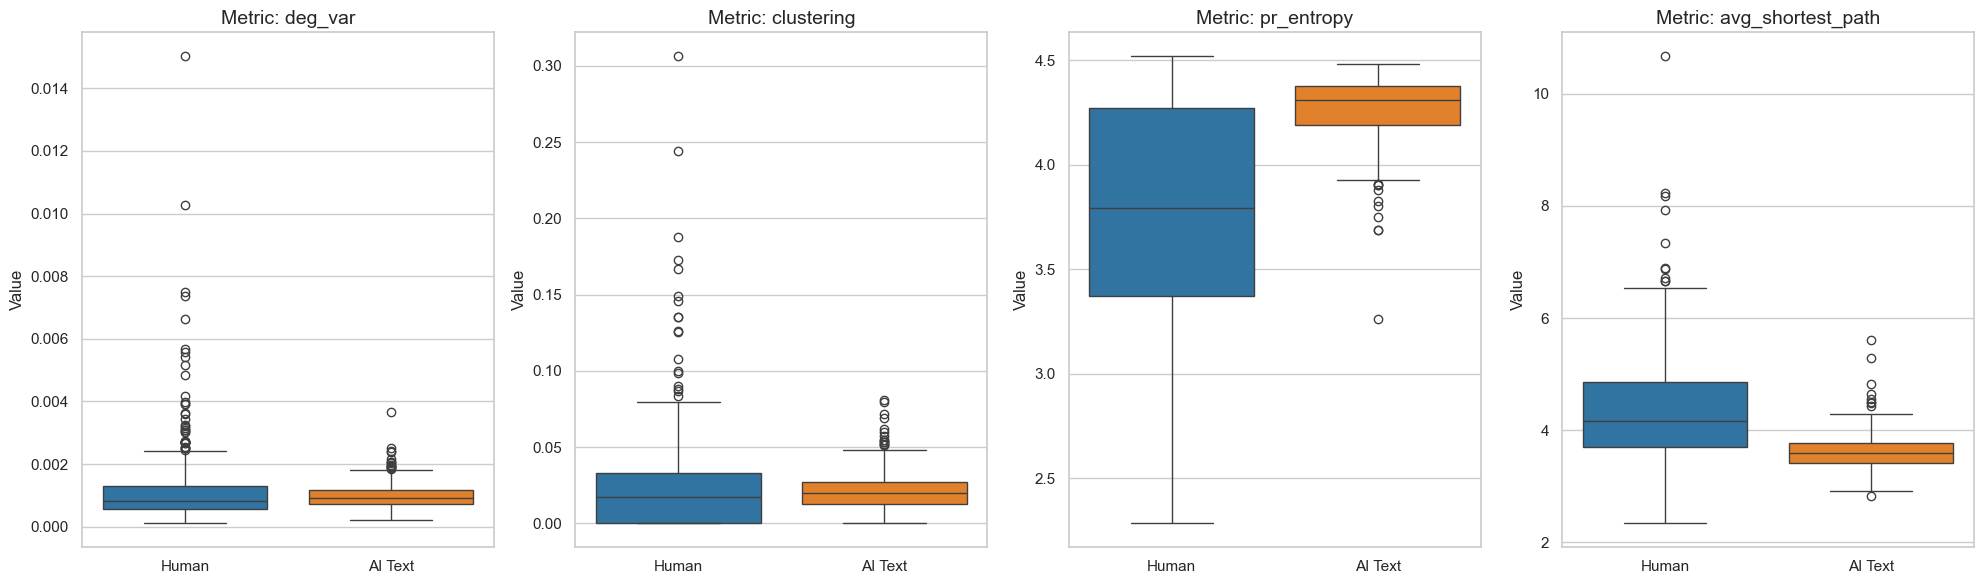

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Reshape the data to a "long" format for Seaborn
plot_df = graph_df.melt(
    id_vars=['qid', 'metric'], 
    value_vars=['human', 'ai'], 
    var_name='Class', 
    value_name='Value'
)

# 2. Clean up labels for display
plot_df['Class'] = plot_df['Class'].replace({'human': 'Human', 'ai': 'AI Text'})
metrics = plot_df['metric'].unique()

# 3. Create a figure with a subplot for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6))

for i, m in enumerate(metrics):
    sns.boxplot(
        data=plot_df[plot_df['metric'] == m], 
        x='Class', 
        y='Value', 
        ax=axes[i], 
        palette={"Human": "#1f77b4", "AI Text": "#ff7f0e"}
    )
    axes[i].set_title(f"Metric: {m}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

### 8. Baseline Linear Models (Length Features)
Logistic Regression achieves ROC-AUC ≈ 0.904 using only basic length/diversity features 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier


In [20]:
def qid_train_test_split(df, test_size=0.2, random_state=42):
    unique_qids = df["qid"].unique()
    rng = np.random.default_rng(random_state)
    rng.shuffle(unique_qids)

    n_test = int(len(unique_qids) * test_size)
    test_qids = set(unique_qids[:n_test])
    train_qids = set(unique_qids[n_test:])

    train_df = df[df["qid"].isin(train_qids)].copy()
    test_df = df[df["qid"].isin(test_qids)].copy()

    return train_df, test_df


train_df_full, test_df_full = qid_train_test_split(dist_df, test_size=0.2)

print("Train qids:", train_df_full["qid"].nunique())
print("Test qids:", test_df_full["qid"].nunique())

Train qids: 19458
Test qids: 4864


In [21]:
base_cols = ["word_len", "char_len", "uniq_words"]

train_base = train_df_full.copy()
test_base = test_df_full.copy()

train_base["lexical_diversity"] = train_base["uniq_words"] / (train_base["word_len"] + 1e-6)
test_base["lexical_diversity"] = test_base["uniq_words"] / (test_base["word_len"] + 1e-6)

base_cols = ["word_len", "char_len", "uniq_words", "lexical_diversity"]

X_train_base = train_base[base_cols]
y_train_base = (train_base["label"] == "ai").astype(int)

X_test_base = test_base[base_cols]
y_test_base = (test_base["label"] == "ai").astype(int)

pipe_base = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

pipe_base.fit(X_train_base, y_train_base)

probs_base = pipe_base.predict_proba(X_test_base)[:, 1]
preds_base = pipe_base.predict(X_test_base)

auc_base = roc_auc_score(y_test_base, probs_base)

print("Baseline Logistic Regression")
print("ROC-AUC:", round(auc_base, 3))
print(classification_report(y_test_base, preds_base))


Baseline Logistic Regression
ROC-AUC: 0.904
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      4864
           1       0.81      0.88      0.84      4771

    accuracy                           0.84      9635
   macro avg       0.84      0.84      0.84      9635
weighted avg       0.84      0.84      0.84      9635



### 9. Extended Feature Model (POS Ratios + Length)
Adds stopword ratio and POS proportions (pronoun/noun/verb/adj); cross-validated ROC-AUC ≈ 0.92

In [ ]:
# Build enriched features ONCE
sample_df = dist_df.copy()

nlp_fast = spacy.load("en_core_web_sm", disable=["ner", "lemmatizer"])

pos_features = []

for doc in nlp_fast.pipe(sample_df["text"], batch_size=64):
    tokens = [t for t in doc if not t.is_punct]
    word_len = len(tokens)
    stop_count = sum(t.is_stop for t in tokens)
    non_stop = word_len - stop_count
    pron = sum(t.pos_ == "PRON" for t in tokens)
    noun = sum(t.pos_ in ("NOUN", "PROPN") for t in tokens)
    verb = sum(t.pos_ == "VERB" for t in tokens)
    adj = sum(t.pos_ == "ADJ" for t in tokens)

    denom = word_len + 1e-6

    pos_features.append({
        "word_len_ns": non_stop,
        "stopword_ratio": stop_count / denom,
        "pronoun_ratio": pron / denom,
        "noun_ratio": noun / denom,
        "verb_ratio": verb / denom,
        "adj_ratio": adj / denom,
    })

feat_extra = pd.DataFrame(pos_features)
feat_df_ns = pd.concat([sample_df.reset_index(drop=True), feat_extra], axis=1)
train_qids = set(train_df_full["qid"])
test_qids = set(test_df_full["qid"])

feat_df_ns["lexical_diversity"] = feat_df_ns["uniq_words"] / (feat_df_ns["word_len"] + 1e-6)


train_enriched = feat_df_ns[feat_df_ns["qid"].isin(train_qids)]
test_enriched  = feat_df_ns[feat_df_ns["qid"].isin(test_qids)]

all_cols = [
    "word_len", "char_len", "uniq_words", "lexical_diversity",
    "word_len_ns", "stopword_ratio", "pronoun_ratio",
    "noun_ratio", "verb_ratio", "adj_ratio"
]

X_train_enriched = train_enriched[all_cols]
y_train_enriched = (train_enriched["label"] == "ai").astype(int)

X_test_enriched = test_enriched[all_cols]
y_test_enriched = (test_enriched["label"] == "ai").astype(int)

In [27]:
pipe_enriched = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=400, class_weight="balanced"))
])

pipe_enriched.fit(X_train_enriched, y_train_enriched)

probs_enriched = pipe_enriched.predict_proba(X_test_enriched)[:, 1]
preds_enriched = pipe_enriched.predict(X_test_enriched)

auc_enriched = roc_auc_score(y_test_enriched, probs_enriched)

print("Enriched Logistic Regression")
print("ROC-AUC:", round(auc_enriched, 3))
print(classification_report(y_test_enriched, preds_enriched))

Enriched Logistic Regression
ROC-AUC: 0.921
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      4864
           1       0.83      0.89      0.86      4771

    accuracy                           0.86      9635
   macro avg       0.86      0.86      0.86      9635
weighted avg       0.86      0.86      0.86      9635



### 10. Linear SVM Comparison
LinearSVC baseline achieves ROC-AUC ≈ 0.920; similar margin behavior across C grid 


In [30]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(class_weight="balanced"))
])

pipe_svm.fit(X_train_enriched, y_train_enriched)

scores_svm = pipe_svm.decision_function(X_test_enriched)
preds_svm = pipe_svm.predict(X_test_enriched)

auc_svm = roc_auc_score(y_test_enriched, scores_svm)

print("Linear SVM")
print("ROC-AUC:", round(auc_svm, 3))
print(classification_report(y_test_enriched, preds_svm))

Linear SVM
ROC-AUC: 0.92
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      4864
           1       0.83      0.90      0.86      4771

    accuracy                           0.86      9635
   macro avg       0.86      0.86      0.86      9635
weighted avg       0.86      0.86      0.86      9635



### 11. Regularization Sweep (C Grid Search)
ROC-AUC remains stable across C ∈ {0.25, 0.5, 1, 2, 4}, indicating margin insensitivity in this feature space 

vertopal

In [ ]:
# ── C-grid on FULL enriched feature set — GroupKFold on qid ──
X  = feat_df_ns[all_cols]
y  = (feat_df_ns["label"] == "ai").astype(int)
groups = feat_df_ns["qid"].values   # prevents qid leakage across CV folds

cs = [0.25, 0.5, 1.0, 2.0, 4.0]
cv = GroupKFold(n_splits=5)

logreg_scores = []
for c in cs:
    pipe_c = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=400, class_weight="balanced", C=c)),
    ])
    aucs = cross_val_score(pipe_c, X, y, cv=cv, groups=groups, scoring="roc_auc")
    logreg_scores.append((c, aucs.mean(), aucs.std()))

print(f"LogReg C sweep (5-fold GroupKFold on qid, n={len(X)})  ROC-AUC mean ± sd:")
for c, m, s in logreg_scores:
    print(f"  C={c:>4}: {m:.4f} ± {s:.4f}")

svm_scores = []
for c in cs:
    pipe_c = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(class_weight="balanced", C=c)),
    ])
    aucs = cross_val_score(pipe_c, X, y, cv=cv, groups=groups, scoring="roc_auc")
    svm_scores.append((c, aucs.mean(), aucs.std()))

print(f"\nLinear SVM C sweep (5-fold GroupKFold on qid, n={len(X)})  ROC-AUC mean ± sd:")
for c, m, s in svm_scores:
    print(f"  C={c:>4}: {m:.4f} ± {s:.4f}")

LogReg C sweep (5-fold GroupKFold on qid, n=48189)  ROC-AUC mean ± sd:
  C=0.25: 0.9182 ± 0.0033
  C= 0.5: 0.9184 ± 0.0033
  C= 1.0: 0.9185 ± 0.0033
  C= 2.0: 0.9185 ± 0.0033
  C= 4.0: 0.9185 ± 0.0033

Linear SVM C sweep (5-fold GroupKFold on qid, n=48189)  ROC-AUC mean ± sd:
  C=0.25: 0.9173 ± 0.0033
  C= 0.5: 0.9173 ± 0.0033
  C= 1.0: 0.9173 ± 0.0033
  C= 2.0: 0.9173 ± 0.0033
  C= 4.0: 0.9173 ± 0.0033


### 12. Character n-gram Hashed Linear Model
3–5 char n-grams with 1M hashed features yield ROC-AUC ≈ 0.998 and ~98% F1, effectively saturating performance

In [ ]:
char_vect = HashingVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    n_features=2**20,
    alternate_sign=False
)

Xc_train = char_vect.transform(train_df_full["text"])
yc_train = (train_df_full["label"] == "ai").astype(int)

Xc_test = char_vect.transform(test_df_full["text"])
yc_test = (test_df_full["label"] == "ai").astype(int)

sgd_clf = SGDClassifier(loss="hinge", max_iter=20, tol=1e-3, class_weight="balanced")
sgd_clf.fit(Xc_train, yc_train)

scores_char = sgd_clf.decision_function(Xc_test)
preds_char = sgd_clf.predict(Xc_test)

auc_char = roc_auc_score(yc_test, scores_char)

print("Character n-gram Model")
print("ROC-AUC:", round(auc_char, 3))
print(classification_report(yc_test, preds_char))

Character n-gram Model
ROC-AUC: 0.998
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4864
           1       0.98      0.99      0.98      4771

    accuracy                           0.98      9635
   macro avg       0.98      0.98      0.98      9635
weighted avg       0.98      0.98      0.98      9635



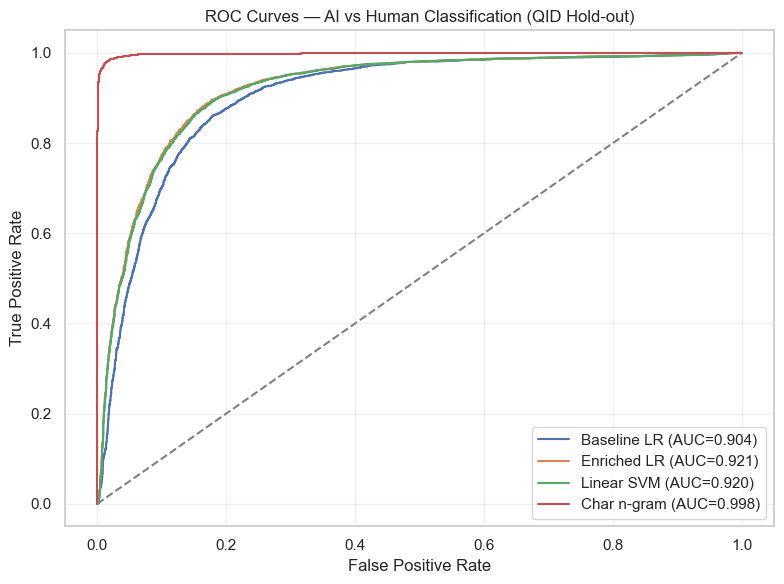

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Use enriched test labels as canonical
y_true = y_test_enriched

fpr_base, tpr_base, _ = roc_curve(y_test_base, probs_base)
fpr_enr, tpr_enr, _   = roc_curve(y_test_enriched, probs_enriched)
fpr_svm, tpr_svm, _   = roc_curve(y_test_enriched, scores_svm)
fpr_char, tpr_char, _ = roc_curve(yc_test, scores_char)

auc_base = auc(fpr_base, tpr_base)
auc_enr  = auc(fpr_enr, tpr_enr)
auc_svm  = auc(fpr_svm, tpr_svm)
auc_char = auc(fpr_char, tpr_char)

plt.figure(figsize=(8,6))

plt.plot(fpr_base, tpr_base, label=f"Baseline LR (AUC={auc_base:.3f})")
plt.plot(fpr_enr,  tpr_enr,  label=f"Enriched LR (AUC={auc_enr:.3f})")
plt.plot(fpr_svm,  tpr_svm,  label=f"Linear SVM (AUC={auc_svm:.3f})")
plt.plot(fpr_char, tpr_char, label=f"Char n-gram (AUC={auc_char:.3f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — AI vs Human Classification (QID Hold-out)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 13. Model Interpretability (SHAP Analysis)

To interpret feature-level contributions in the enriched logistic regression model, we apply SHAP (SHapley Additive Explanations). 

Since the classifier is linear, SHAP values correspond directly to scaled feature contributions toward AI classification. This allows us to identify which structural and linguistic features most strongly influence model decisions.


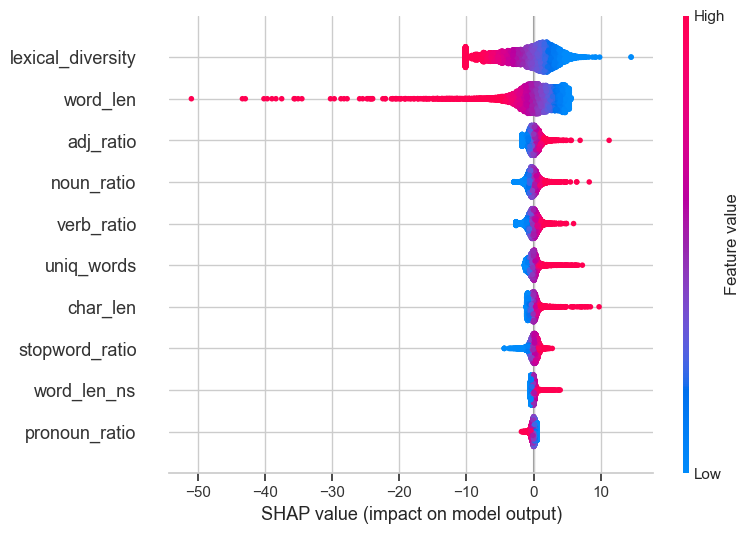

,feature,coefficient
0,word_len,-3.973037
3,lexical_diversity,-3.809272
9,adj_ratio,0.815391
7,noun_ratio,0.793467
1,char_len,0.779062
2,uniq_words,0.755969
8,verb_ratio,0.748100
5,stopword_ratio,0.610241
4,word_len_ns,0.347246
6,pronoun_ratio,-0.267385


In [37]:
import shap

scaler = pipe_enriched.named_steps["scaler"]
clf = pipe_enriched.named_steps["clf"]

X_train_scaled = scaler.transform(X_train_enriched)
X_test_scaled = scaler.transform(X_test_enriched)

explainer = shap.LinearExplainer(clf, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_enriched, feature_names=all_cols)


coef_df = pd.DataFrame({
    "feature": all_cols,
    "coefficient": pipe_enriched.named_steps["clf"].coef_[0]
}).sort_values("coefficient", key=abs, ascending=False)

coef_df